In [1]:
import re
import requests
import random
import numpy as np
import pandas as pd
import csv
import seaborn as sns

from selenium import webdriver  # необходимо использовать selenium для навигации и принятия согласия (иначе на сайт не пустит)
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from time import sleep
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

sns.set()

RANDOM_STATE = 32 # для воспроизводимости результатов
BASE_URL = 'https://auto.ru/cars/all/?sort=fresh_relevance_1-desc&output_type=list&page={}'
NUM_PAGES = 30 #сколько страниц на сайте парсим
USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36'

D:\Anaconda\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.0.0' currently installed).
  warnings.warn(msg, UserWarning)


# Парсинг данных об автомобилях
Для парсинга будем использовать один из крупнейших сайтов купли/продажи автомобилей на территории РФ - [auto.ru](https://auto.ru). Для каждого автомобиля с сайта будем извлекать следующие данные:
- **car_model** - марка автомобиля
- **price** - цена автомобиля (руб.)
- **km_age** - пробег автомобиля (км.)
- **manufacture_year** - год выпуска
- **engine_capacity** - объем двигателя (л)
- **engine_power** - мощность двигателя (л.с.)
- **fuel** - топливо
- **link** - ссылка на машину

In [93]:
# возвращает html-код страницы по ее номеру в случае успешного запроса
def get_page_content(page_number):
    response = requests.get(BASE_URL.format(page_number), headers = {'User-Agent': USER_AGENT})
    if response.status_code == 200:
        return response.content
    else:
        return None

In [94]:
# возвращает марку модели
def get_car_model(car_soup):
    try:
        return car_soup.find('a', attrs={'class':re.compile(".*Title.*")}).text
    except Exception as e:
        print("Ошибка извлечения марки машины {} : \n {}".format(get_car_link(car_soup), str(e)))
        return np.nan

In [95]:
#возвращает цену машины
def get_car_price(car_soup):
    try:
        price = car_soup.find('div', attrs={'class':re.compile(".*Price$")}).div.text
        return re.sub("\D","",price) # '1\xa0330\xa0000\xa0₽' - > 1330000
    except Exception as e:
        print("Ошибка извлечения цены машины {}: \n {}".format(get_car_link(car_soup), str(e)))
        return np.nan

In [96]:
#возвращает пробег машины
def get_km_age(car_soup):
    try:
        km_age = car_soup.find('div', attrs={'class':re.compile(".*KmAge$")}).div.text
        return re.sub("\D","",km_age)
    except Exception as e:
        print("Ошибка извлечения пробега машины {}: \n {}".format(get_car_link(car_soup), str(e)))
        return np.nan

In [97]:
#возвращает год выпуска машины
def get_manufacture_year(car_soup):
    try:
        return car_soup.find('div', attrs={'class':re.compile(".*year$")}).text
    except Exception as e:
        print("Ошибка извлечения года выпуска машины {}: {}".format(get_car_link(car_soup), str(e)))
        return np.nan

In [98]:
#возвращает информацию о двигателе машины
def get_engine_info(car_soup):
    engine_capacity, engine_power, fuel = (np.nan,)*3
    try:
        engine_info = car_soup.find('div', attrs={'class':'ListingItemTechSummary-module__cell'}).text
        for info in engine_info.split('/'):
            if 'л.' in info:
                engine_power = parse_numbers(info)
            elif info.strip() in ['Бензин', 'Дизель', 'Гибрид', 'Электро']:
                fuel = info.strip()                
            elif 'л' in info:
                engine_capacity = parse_numbers(info)
        return engine_capacity, engine_power, fuel
    except Exception as e:
        print("Ошибка извлечения информации о двигателе машины {} : {}".format(get_car_link(car_soup), str(e)))
        return (np.nan,)*3

In [99]:
def get_car_link(car_soup):
    try:
        return car_soup.find('a', attrs={'class':re.compile(".*Title.*")})['href']
    except Exception as e:
        print("Ошибка извлечения ссылки на машину: {}".format(str(e)))
        return np.nan   

In [100]:
# вспомогательная функция: извлекает число из строки
def parse_numbers(text):
    return re.findall(r"\d+\.?\d*", text)[0]

In [109]:
# нажимает на кнопку принять при открытии сайта
def click_accept(diver):
    try:
        driver.find_element_by_css_selector('#confirm-button').click()
    except Exception as e:
        print("Не удалось зайти на сайт \n".format(str(e)))

In [113]:
# переходит на следующую страницу и возвращает ее содержимое
def get_next_page_content(driver):
    driver.find_element_by_xpath('//*[@id="listing-filters"]/div[10]/div/div/a[2]/span/span').click()
    return driver.page_source

In [117]:
cars_info = []  #список, куда будем записывать найденную информацию
cars_info.append(['car_model','price','km_age','manufacture_year', 'engine_capacity', 'engine_power', 'fuel', 'link'])

driver = webdriver.Firefox() # открываем браузер
driver.get('https://auto.ru') # переходим на сам сайт
click_accept(driver) # нажимаем на кнопку принять
driver.get(BASE_URL.format(1)) # перехожу на первую страницу
page_content = driver.page_source # забираю html-код страницы

for page_number in range(1,NUM_PAGES + 1):
    print("Обрабатываем страницу № {}".format(page_number))
    if page_content is None:
        print("Возникла ошибка при получении запроса")
        break
    page_soup = BeautifulSoup(page_content, 'lxml')
    # извлекаем список автомобилей с текущей страницы
    page_cars = page_soup.findAll('div', attrs={'class':'ListingItem-module__container ListingCars-module__listingItem'})
    print("Получено {} машин".format(len(page_cars)))
    for car in page_cars:
        link = get_car_link(car)
        car_model = get_car_model(car) # извлекаем марку машины
        price = get_car_price(car) # извлекаем цену
        km_age = get_km_age(car) # и т.д
        manufacture_year = get_manufacture_year(car)
        engine_capacity, engine_power, fuel = get_engine_info(car)
        cars_info.append([car_model, price, km_age, manufacture_year, engine_capacity, engine_power, fuel, link])
    sleep(random.gauss(3,1)) # чтобы делать случайные перерывы между запросами (в данном случае нормальное распределение со средним 3 и дисперсией 1)
    page_content = get_next_page_content(driver)

Обрабатываем страницу № 1
Получено 37 машин
Обрабатываем страницу № 2
Получено 37 машин
Обрабатываем страницу № 3
Получено 37 машин
Обрабатываем страницу № 4
Получено 37 машин
Обрабатываем страницу № 5
Получено 37 машин
Обрабатываем страницу № 6
Получено 37 машин
Обрабатываем страницу № 7
Получено 37 машин
Обрабатываем страницу № 8
Получено 37 машин
Обрабатываем страницу № 9
Получено 37 машин
Обрабатываем страницу № 10
Получено 37 машин
Обрабатываем страницу № 11
Получено 37 машин
Обрабатываем страницу № 12
Получено 37 машин
Обрабатываем страницу № 13
Получено 37 машин
Обрабатываем страницу № 14
Получено 37 машин
Обрабатываем страницу № 15
Получено 37 машин
Обрабатываем страницу № 16
Получено 37 машин
Обрабатываем страницу № 17
Получено 37 машин
Обрабатываем страницу № 18
Получено 37 машин
Обрабатываем страницу № 19
Получено 37 машин
Обрабатываем страницу № 20
Получено 37 машин
Обрабатываем страницу № 21
Получено 37 машин
Обрабатываем страницу № 22
Получено 37 машин
Обрабатываем страни

Сохраним данные в отдельный csv файл

In [129]:
with open('cars.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(cars_info)

# Разведочный анализ датасета (Exploratory data analysis)

In [2]:
cars_df = pd.read_csv('cars.csv') # считываем данные с файла

In [3]:
cars_df.head()

,car_model,price,km_age,manufacture_year,engine_capacity,engine_power,fuel,link
0,Land Rover Range Rover IV,2750000,129500.0,2015,3.0,340,Бензин,https://auto.ru/cars/used/sale/land_rover/rang...
1,Renault Logan II Рестайлинг,547745,NaN,2019,1.6,82,Бензин,https://auto.ru/cars/new/group/renault/logan/2...
2,Toyota Land Cruiser 200 Series Рестайлинг 2,3500000,110000.0,2016,4.5,249,Дизель,https://auto.ru/cars/used/sale/toyota/land_cru...
3,Subaru Legacy II,85000,280000.0,1997,2.0,115,Бензин,https://auto.ru/cars/used/sale/subaru/legacy/1...
4,Mazda 3 I (BK) Рестайлинг,340000,144000.0,2008,1.6,105,Бензин,https://auto.ru/cars/used/sale/mazda/3/1094689...


#### Обработка пропусков

In [4]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 8 columns):
car_model           985 non-null object
price               985 non-null int64
km_age              821 non-null float64
manufacture_year    985 non-null int64
engine_capacity     984 non-null float64
engine_power        985 non-null int64
fuel                985 non-null object
link                985 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 61.7+ KB


Из общей информации о нашем наборе данных видим, присутствует признак `km_age`, у которого есть пропуски, а также `engine_capacity`, у которого только один пропуск.   

И прежде чем заменять пропуски в `km_age` на медианные значения, давайте посмотрим, а какого года выпуска машины с отсутствием пробега. 

In [5]:
cars_df[cars_df['km_age'].isnull()]['manufacture_year'].value_counts()

2019    163
2018      1
Name: manufacture_year, dtype: int64

Видим, что 163 машины с пропуском пробега - это машины 2019 года выпуска и 1 - 2018. Это все новые машины для машины 2018 года убеждаемся найдя на ее ссылку и проверив на сайте). Поэтому давайте заменим имеющиеся пропуски на 0.

In [6]:
cars_df['km_age'].fillna(0, inplace=True)

У признака `engine_capacity` всего 1 пропуск. Поэтому можем просто удалить эту машину из набора данных.

In [7]:
cars_df.dropna(inplace=True)

In [8]:
cars_df.info() # теперь пропусков у нас не должно быть

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 984
Data columns (total 8 columns):
car_model           984 non-null object
price               984 non-null int64
km_age              984 non-null float64
manufacture_year    984 non-null int64
engine_capacity     984 non-null float64
engine_power        984 non-null int64
fuel                984 non-null object
link                984 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 69.2+ KB


Давайте еще немного предобработаем наш датасет. Чтобы не работать с огромными числами, давайте преобразуем в другие единицы измерения следующие признаки: `price`, `km_age`. Пусть цена `price` будет измеряться в млн.руб (сейчас в руб.), `km_age` - в тыс.км. (сейчас в км). 

In [9]:
cars_df['price'] = cars_df['price']/1000000
cars_df['km_age'] = cars_df['km_age']/1000

D:\Anaconda\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.5' currently installed).
  warnings.warn(msg, UserWarning)


У нас присутствует несколько категориальных признаков: `car_model`,`fuel` (признак `link` мы не будем использовать ни для кластеризации ни для регрессии. Это чисто справочный признак). Для признака `car_model` выполним **OneHotEncoding**, для признака `fuel` - **LabelEncoding**. Кроме этого **вручную выполним encoding** для признака `manufacture_age`.   
Но прежде всего давайте предобработаем наш признак `car_model`. Для этого из всего названия марки машины вместе с серией и т.п (сейчас наш признак именно такой) извлечем только саму марку (**Chevrolet Cruze I Рестайлинг - > Chevrolet**)

#### OneHotEncoding

In [10]:
# преобразование Chevrolet Cruze I Рестайлинг - > Chevrolet
cars_df['car_model'] = cars_df['car_model'].apply(lambda x: " ".join(x.split(" ")[:1]))

В pandas есть встроенная возможность для OneHotEncoding **get_dummies** и она более удобная чем OneHotEncoding из sklearn

In [11]:
cars_df = pd.get_dummies(cars_df, prefix_sep='_', columns=['car_model'], drop_first=True)

In [12]:
cars_df.head()

,price,km_age,manufacture_year,engine_capacity,engine_power,fuel,link,car_model_Audi,car_model_BMW,car_model_Bentley,...,car_model_Skoda,car_model_SsangYong,car_model_Subaru,car_model_Suzuki,car_model_Toyota,car_model_Volkswagen,car_model_Volvo,car_model_ГАЗ,car_model_ИЖ,car_model_УАЗ
0,2.750000,129.5,2015,3.0,340,Бензин,https://auto.ru/cars/used/sale/land_rover/rang...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.547745,0.0,2019,1.6,82,Бензин,https://auto.ru/cars/new/group/renault/logan/2...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.500000,110.0,2016,4.5,249,Дизель,https://auto.ru/cars/used/sale/toyota/land_cru...,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.085000,280.0,1997,2.0,115,Бензин,https://auto.ru/cars/used/sale/subaru/legacy/1...,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.340000,144.0,2008,1.6,105,Бензин,https://auto.ru/cars/used/sale/mazda/3/1094689...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### LabelEncoding

Видим, что преобразование выполнилось успешно. Теперь сделаем **LabelEncoding** для признака `fuel`

In [13]:
le = LabelEncoder()
cars_df[['fuel']] = cars_df[['fuel']].apply(lambda col: le.fit_transform(col))

Разделим теперь наш датасет на `X` - описание машины, которое будем использовать для прогнозирования и `Y` - целевой признак (в нашем случае это цена машины). 

In [14]:
links = cars_df['link']
cars_df.drop('link', axis=1, inplace=True)

In [15]:
X = cars_df.loc[:,'km_age':]
Y = cars_df['price']

In [16]:
X.head()

,km_age,manufacture_year,engine_capacity,engine_power,fuel,car_model_Audi,car_model_BMW,car_model_Bentley,car_model_Cadillac,car_model_Chery,...,car_model_Skoda,car_model_SsangYong,car_model_Subaru,car_model_Suzuki,car_model_Toyota,car_model_Volkswagen,car_model_Volvo,car_model_ГАЗ,car_model_ИЖ,car_model_УАЗ
0,129.5,2015,3.0,340,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,2019,1.6,82,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,110.0,2016,4.5,249,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,280.0,1997,2.0,115,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,144.0,2008,1.6,105,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Encoding вручную

In [17]:
X['manufacture_year'].sort_values().unique() # уникальные года

array([1983, 1987, 1988, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

В этом случае мы не будем для каждого года ставить свою метку. Мы будем смотреть в какой из заданных ранее диапазонов значение попало и ставить соответствующую метку.  


Разобьем интервал с 1983 года по 2019 на следующие интервалы:
- [1983, 1990]
- [1991, 2000]
- [2001, 2010]
- [2011, 2019]

In [18]:
def year_encoding(year):
    if year<=1990:
        return 0
    elif year >= 1991 and year <= 2000:
        return 1
    elif year >=2001 and year <=2010:
        return 2
    return 3

In [19]:
X['manufacture_year'] = X['manufacture_year'].apply(year_encoding)

In [20]:
X.head()

,km_age,manufacture_year,engine_capacity,engine_power,fuel,car_model_Audi,car_model_BMW,car_model_Bentley,car_model_Cadillac,car_model_Chery,...,car_model_Skoda,car_model_SsangYong,car_model_Subaru,car_model_Suzuki,car_model_Toyota,car_model_Volkswagen,car_model_Volvo,car_model_ГАЗ,car_model_ИЖ,car_model_УАЗ
0,129.5,3,3.0,340,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,3,1.6,82,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,110.0,3,4.5,249,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,280.0,1,2.0,115,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,144.0,2,1.6,105,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Нормализация вещественных признаков
Посмотрим на разброс вещественных признаков

In [21]:
real_cols = ['km_age', 'engine_capacity', 'engine_power']

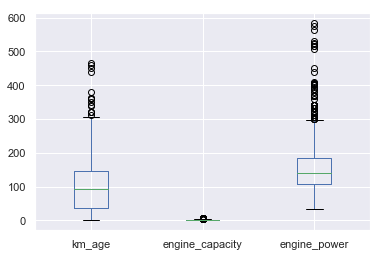

In [22]:
X[real_cols].boxplot()

Видим, что признаки `km_age` , `engine_power` имеют достаточно большой разброс по сравнению с `engine_capacity`. Поэтому давайте выполним нормализацию данных признаков    
**ЗАМЕЧАНИЕ** Большой разброс значений у одних признаков и маленький у других может негативно сказаться на качестве модели

In [23]:
X[real_cols] = StandardScaler().fit_transform(X[real_cols])

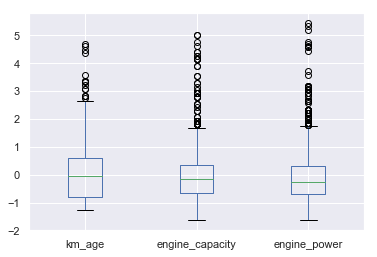

In [24]:
X[real_cols].boxplot() #разброс после стандартизации

Построим также корреляционную матрицу

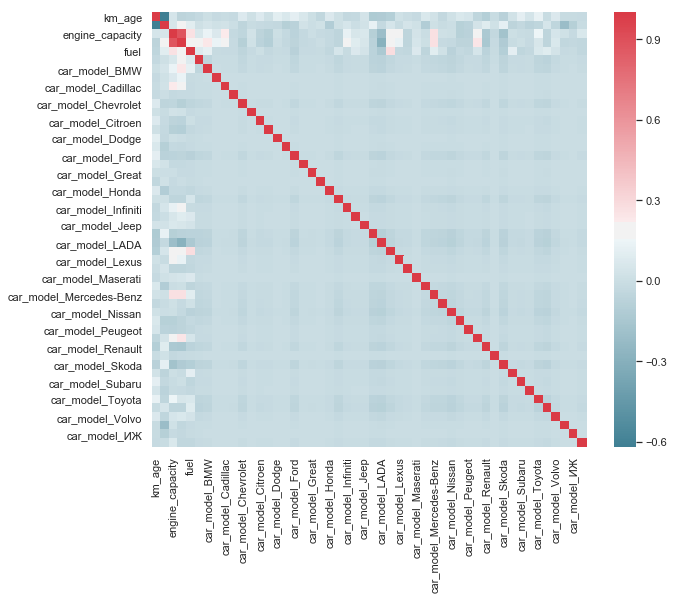

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Видим достаточно сильную корреляцию между топливом и машиной BMW. Наверное большинство машин BMW из нашего датасета используют только один тип топлива

Теперь наши данные готовы для кластеризации и построения предиктивной модели

# Кластеризация

В качестве алгоритма кластеризации возьмем алгоритм K-means. А оптимальное количество кластеров будем подбирать используя ``критерий каменистой осыпи``. В качестве метрики качества кластеризации будем считать суммарное межкластерное расстояние (**WCSS**)

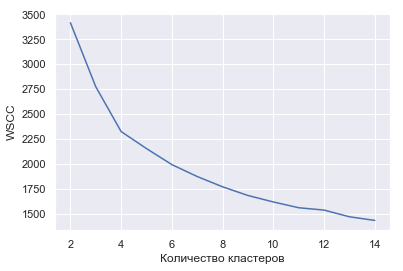

In [25]:
wcss = []
MAX_N_CLUSTERS = 15
for n_clusters in range(2, MAX_N_CLUSTERS):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++', max_iter=800, random_state=RANDOM_STATE)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, MAX_N_CLUSTERS), wcss)
plt.xlabel('Количество кластеров')
plt.ylabel('WSCC')
plt.show()

In [26]:
n_clusters = 4

По критерию каменистой осыпи - оптимальное количество кластеров равно 3   


Выполним кластеризацию с оптимальным количеством кластеров и визуализируем наши кластеры

In [27]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=800, random_state=RANDOM_STATE)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=800, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=32, tol=0.0001,
    verbose=0)

Для того, чтобы визуализировать наши кластеры необходимо сначала снизить размерность наших данных. Для этого будем использовать метод главных компонент.

In [28]:
pca = decomposition.PCA(n_components=2)
X_pca  = pca.fit_transform(X)

Text(0, 0.5, 'Вторая главная компонента')

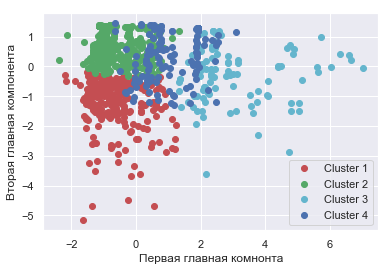

In [29]:
#отрисовываем кластеры
labels = kmeans.labels_
plt.plot(X_pca[labels == 0, 0], X_pca[labels == 0, 1], 'ro', label='Cluster 1')
plt.plot(X_pca[labels == 1, 0], X_pca[labels == 1, 1], 'go', label='Cluster 2')
plt.plot(X_pca[labels == 2, 0], X_pca[labels == 2, 1], 'co', label='Cluster 3')
plt.plot(X_pca[labels == 3, 0], X_pca[labels == 3, 1], 'bo', label='Cluster 4')
plt.legend()
plt.xlabel('Первая главная комнонта')
plt.ylabel('Вторая главная компонента')

Видно, что проекции кластеров достаточно сильно накладываются друг на друга. Исходя из этой визуализации можно увидеть, что объекты 3 кластера имеют большее значение по первой компоненте, объекты 1 кластера - по второй, а объекты 2 и 4 кластеров - примерно одинаковые значения по каждой из компонент. Для более детального понимания кластеров давайте рассмотреть матрицу нагрузок, которая покажет нам, какие из признаков больше всего вносят вклад в первую компоненту, а какие во вторую

In [30]:
np.round(pca.components_, 1) 

array([[-0. ,  0.1,  0.7,  0.7,  0.2,  0. ,  0. ,  0. ,  0. , -0. , -0. ,
         0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,
         0. ,  0. ,  0. , -0. , -0.1,  0. ,  0. , -0. ,  0. , -0. ,  0. ,
         0. , -0. , -0. , -0. ,  0. , -0. , -0. , -0. ,  0. , -0. , -0. ,
         0. , -0. ,  0. , -0. , -0. ,  0. ],
       [-0.9,  0.4, -0.1,  0. ,  0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,
        -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0. , -0. , -0. ,
         0. ,  0. , -0. ,  0. ,  0. ,  0. , -0. ,  0. ,  0. , -0. , -0. ,
         0. , -0. , -0. , -0. ,  0. ,  0. ,  0. ,  0. , -0. , -0. , -0. ,
        -0. ,  0. , -0. , -0. , -0. ,  0. ]])

Видим, что значения первой компоненты в основном определяется признаками 3 и 4 (`engine_capacity` и `engine_power`), а второй компоненты - признаками 1 и 2 (`km_age`,`manufacture_age`). Исходя из этого можем предположить, что машины были разбиты на кластеры исходя из показателей двигателя и изношенности машины.  

Посмотрим также на сами машины по каждому кластеру, а точнее на статистику по признакам, которые мы указали выше

In [31]:
# кластер 1 (красный)
cols = ['km_age', 'manufacture_year', 'engine_capacity', 'engine_power']
cars_df.loc[kmeans.labels_ == 0, cols].describe()

,km_age,manufacture_year,engine_capacity,engine_power
count,290.000000,290.000000,290.000000,290.000000
mean,179.178852,2006.703448,1.827586,126.731034
std,65.283770,4.627470,0.405069,42.396506
min,46.410000,1983.000000,0.800000,52.000000
25%,137.743500,2005.000000,1.600000,97.000000
50%,161.192000,2008.000000,1.700000,120.000000
75%,204.000000,2010.000000,2.000000,147.000000
max,465.000000,2017.000000,3.000000,260.000000


В первый кластер входят машины, проехавшие в среднем больше других

In [32]:
# кластер 2 (зеленый)
cars_df.loc[kmeans.labels_ == 1, cols].describe()

,km_age,manufacture_year,engine_capacity,engine_power
count,451.000000,451.000000,451.000000,451.000000
mean,52.618965,2015.161863,1.775831,133.044346
std,43.963954,3.623131,0.331148,38.602507
min,0.000000,1994.000000,0.800000,33.000000
25%,0.000000,2013.000000,1.600000,106.000000
50%,53.300000,2015.000000,1.600000,126.000000
75%,90.032500,2019.000000,2.000000,150.000000
max,137.540000,2019.000000,3.000000,252.000000


Во второй кластер входят самые слабые по мощности и объему бака машины и проехавшие в среднем меньше других.

In [33]:
# кластер 3 (голубой)
cars_df.loc[kmeans.labels_ == 2, cols].describe()

,km_age,manufacture_year,engine_capacity,engine_power
count,100.000000,100.000000,100.000000,100.000000
mean,107.210880,2012.330000,3.977000,326.230000
std,69.162995,3.918501,0.885786,87.026741
min,0.000000,2003.000000,3.000000,202.000000
25%,63.350000,2010.000000,3.500000,249.750000
50%,101.750000,2012.000000,3.600000,306.000000
75%,154.250000,2015.000000,4.500000,367.000000
max,362.646000,2019.000000,6.200000,585.000000


Действительно, в 3 кластер входят машины с большим объемом бака и мощностью двигателя

In [34]:
# кластер 4 (синий)
cars_df.loc[kmeans.labels_ == 3, cols].describe()

,km_age,manufacture_year,engine_capacity,engine_power
count,143.000000,143.000000,143.000000,143.000000
mean,76.103182,2014.328671,2.548252,200.867133
std,61.653894,3.949998,0.458235,51.204263
min,0.000000,2004.000000,1.500000,102.000000
25%,10.263500,2011.500000,2.100000,165.000000
50%,70.000000,2015.000000,2.500000,190.000000
75%,125.606000,2018.000000,3.000000,249.000000
max,188.000000,2019.000000,3.600000,381.000000


В этот кластер входят машины имеющие в целом средние показатели по пробегу и по пробегу

# Регрессия

В качестве предиктивной модели будем использовать модель линейной регрессии. А в качестве метрики качества - Mean Absolute Error, поскольку она в данном случае будет легко интерпретироваться и обозначать - на сколько млн. рублей наша модель в среднем ошибается.   

Для начала разделим всю выборку на обучающую и тестовую.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

Теперь обучим модель на `X_train` и протестируем на `X_test`

In [65]:
model = Lasso(random_state=RANDOM_STATE, alpha=0.005)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
MAE = metrics.mean_absolute_error(y_test, y_pred)
print("MAE = {:.3} млн руб".format(MAE))

MAE = 0.532 млн руб


Отбразим коэффициенты линейной регрессии, которые можно интерпретировать как важность признака для прогноза

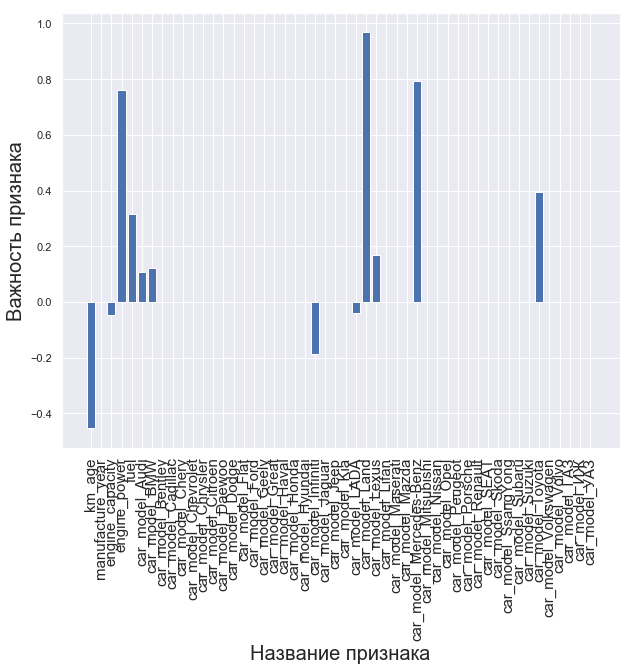

In [74]:
plt.rcParams['figure.figsize'] = (10,8)
index = np.arange(len(X_train.columns))
plt.bar(index, model.coef_)
plt.xlabel('Название признака', fontsize=20)
plt.ylabel('Важность признака', fontsize=20)
plt.xticks(index, X_train.columns, fontsize=15, rotation=90)
plt.show()

И сразу заметим, что на цену машины влияет, является ли она Mecedes-Benz или нет, а также пробег, мощность двигателя и т.д.